In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

In [2]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [3]:
def mod_df(df, ix, c):
    arr_count = np.stack(df.loc[ix, 'onehot_count'])
    arr_count[:, c] = 0
    series_count = pd.Series(list(arr_count), index=ix)  # convert to series of arrays
    
    arr_area = np.stack(df.loc[ix, 'onehot_area'])
    arr_area[:, c] = 0
    series_area = pd.Series(list(arr_area), index=ix)  # convert to series of arrays
    
    arr_length = np.stack(df.loc[ix, 'onehot_length'])
    arr_length[:, c] = 0
    series_length = pd.Series(list(arr_length), index=ix)  # convert to series of arrays

    df.loc[ix, 'onehot_count'] = series_count
    df.loc[ix, 'onehot_area'] = series_area
    df.loc[ix, 'onehot_length'] = series_length

# Train on all OSM classes (emb v1)

In [5]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)
dl.disable_chip_loading = True

2024-05-16 20:06:12.139 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-16 20:06:15.519 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-16 20:06:15.519 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-16 20:06:16.109 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-16 20:06:16.781 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-16 20:06:16.782 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-16 20:06:1

In [6]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

In [7]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.16446 params 0.0381606
epoch   1 step 3662 loss 0.14704 params 0.0620447
epoch   2 step 3662 loss 0.15197 params 0.0926610
epoch   3 step 3662 loss 0.14274 params 0.1238475
epoch   4 step 3662 loss 0.13593 params 0.1556941
epoch   5 step 3662 loss 0.13998 params 0.1879542
epoch   6 step 3662 loss 0.13453 params 0.2205353
epoch   7 step 3662 loss 0.13309 params 0.2531614
epoch   8 step 3662 loss 0.13443 params 0.2858000
epoch   9 step 3662 loss 0.14169 params 0.3184490
epoch  10 step 3662 loss 0.12122 params 0.3509715
epoch  11 step 3662 loss 0.12712 params 0.3835408
epoch  12 step 3662 loss 0.12779 params 0.4159570
epoch  13 step 3662 loss 0.13040 params 0.4479125
epoch  14 step 3662 loss 0.12898 params 0.4795884
epoch  15 step 3662 loss 0.13778 params 0.5111611
epoch  16 step 3662 loss 0.12568 params 0.5423496
epoch  17 step 3662 loss 0.12984 params 0.5732989
epoch  18 step 3662 loss 0.12965 params 0.6040593
epoch  19 step 3662 loss 0.12764 params 0.6348144


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



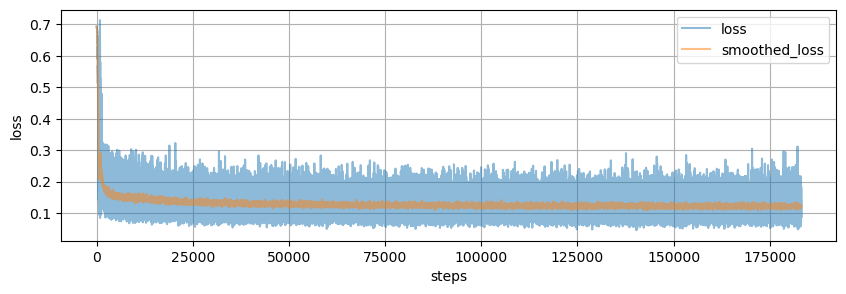

In [9]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [10]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:12 Time:  0:00:120001


((58598, 99), (58598, 99))

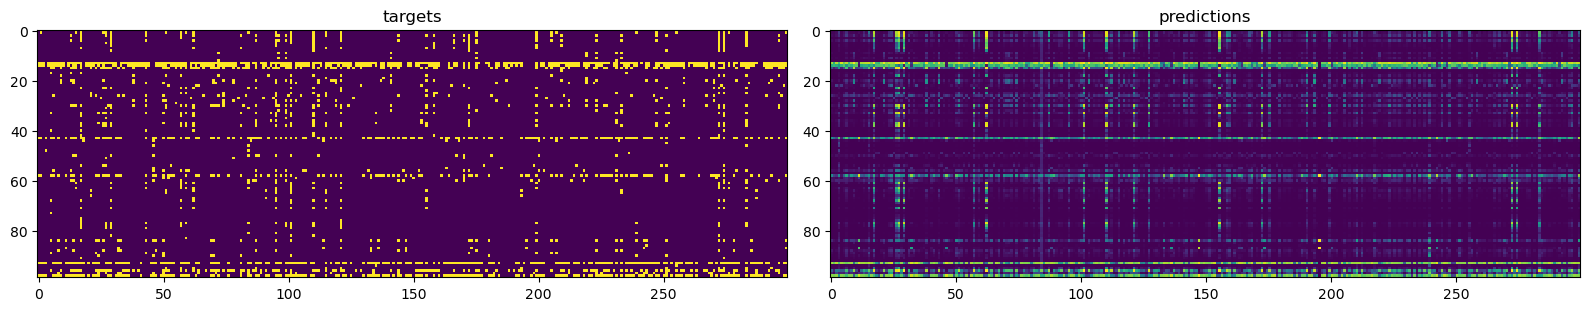

In [11]:
idxs = np.random.permutation(len(targets))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [12]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5807649267885593, 'prec': 0.7403997569903068}

In [13]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

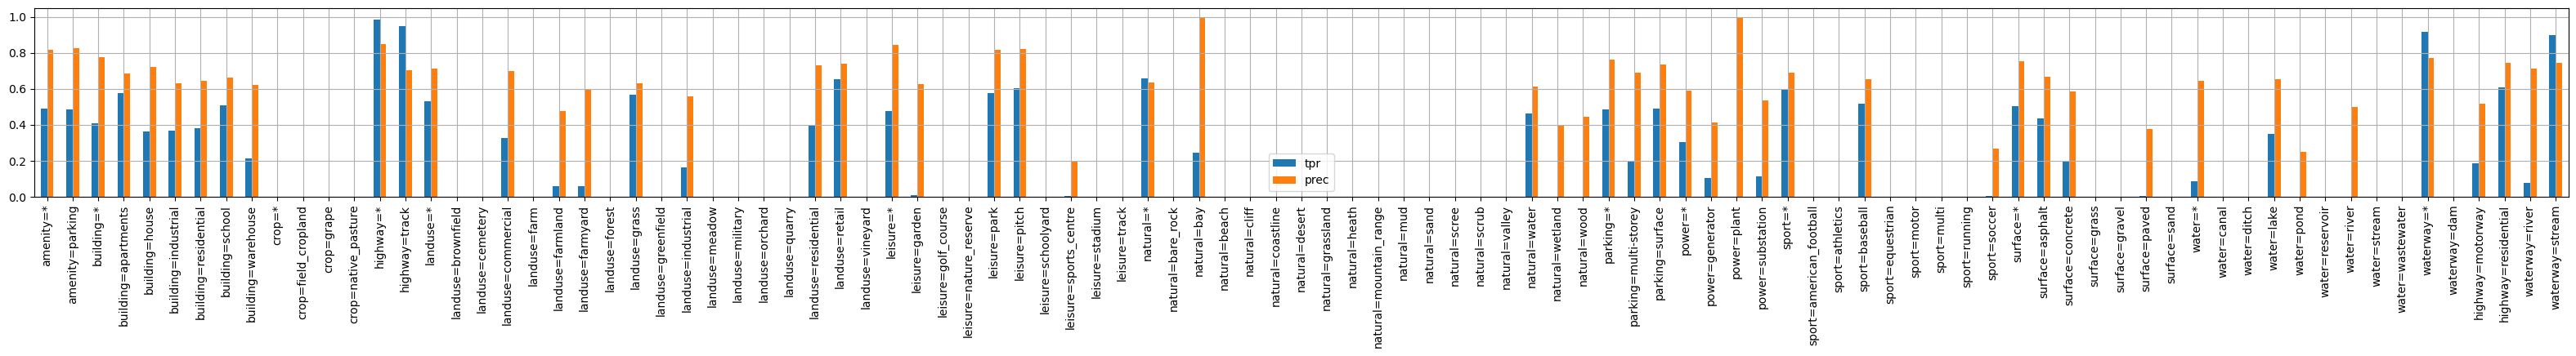

In [14]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(99)), rotation=90, fontsize=10);

In [15]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:01:44 Time:  0:01:440109


(100, 99, 2)

Classes to retain based on the below

In [22]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 9, 13, 14,
                  18, 23, 30, 31, 33, 37, 43, 45, 58, 61,
                  68, 71, 84, 87, 93, 96, 97, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

28
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
9 crop=*
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


<Figure size 640x480 with 0 Axes>

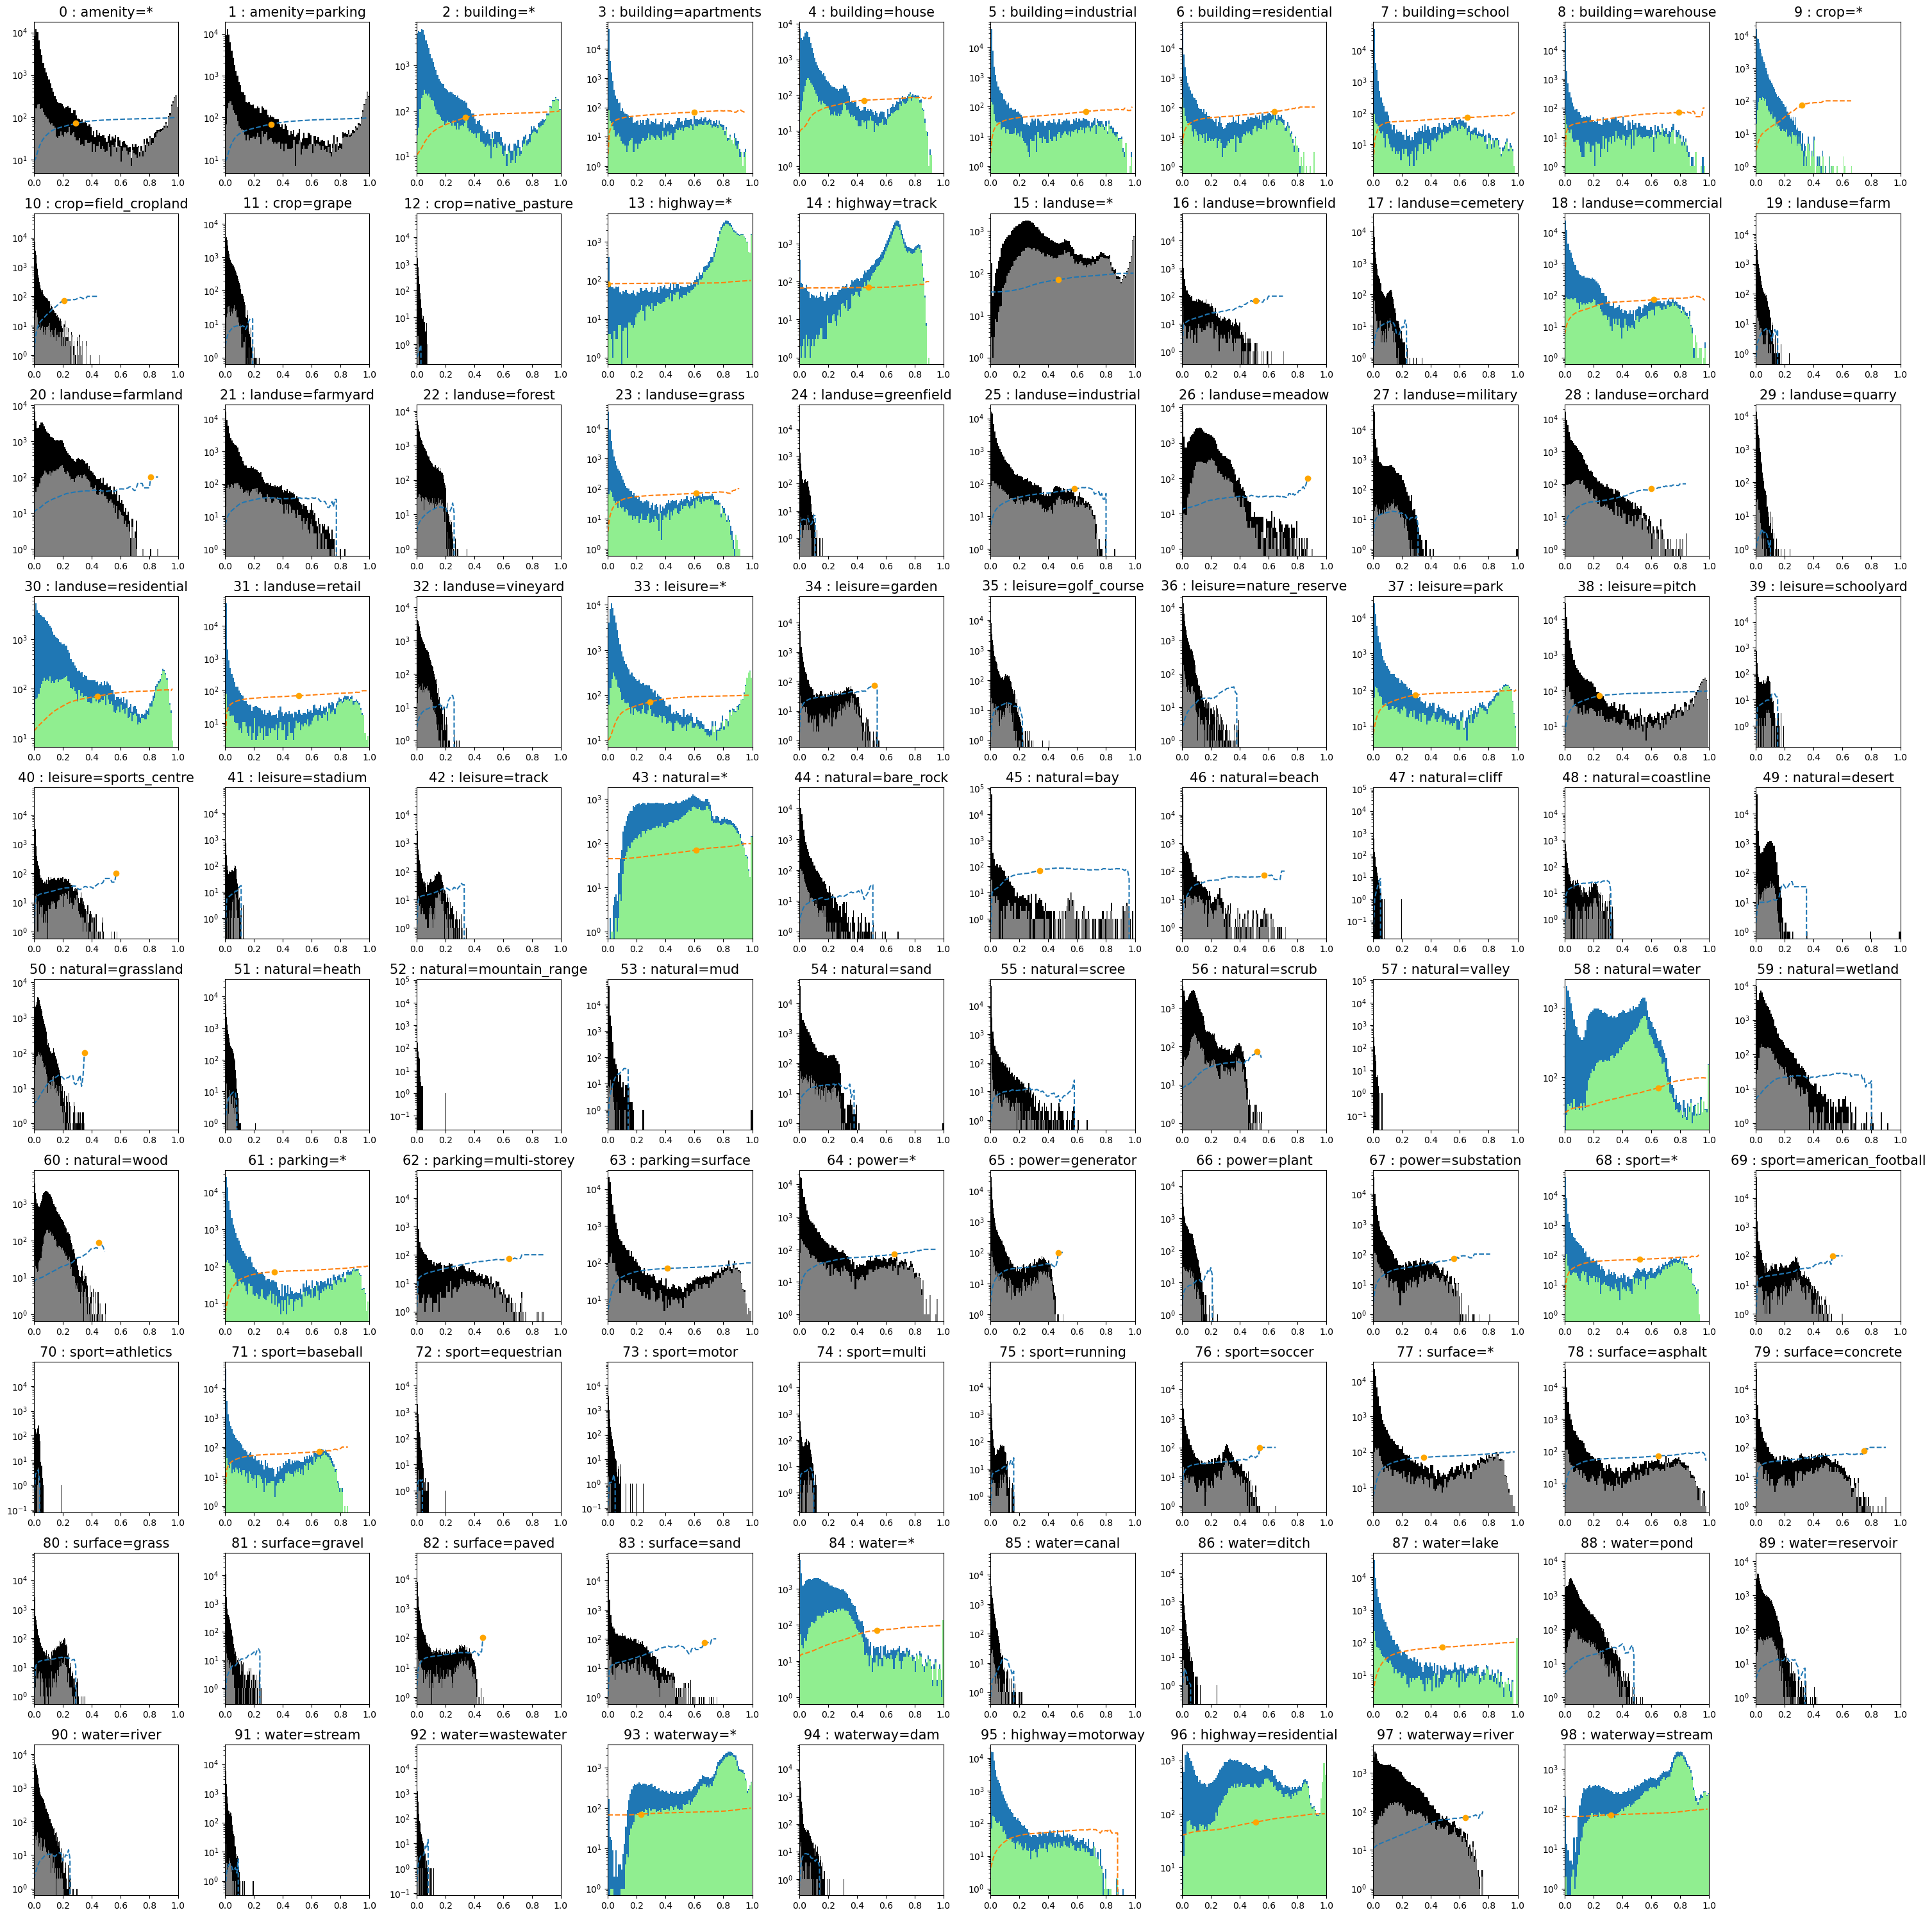

In [20]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

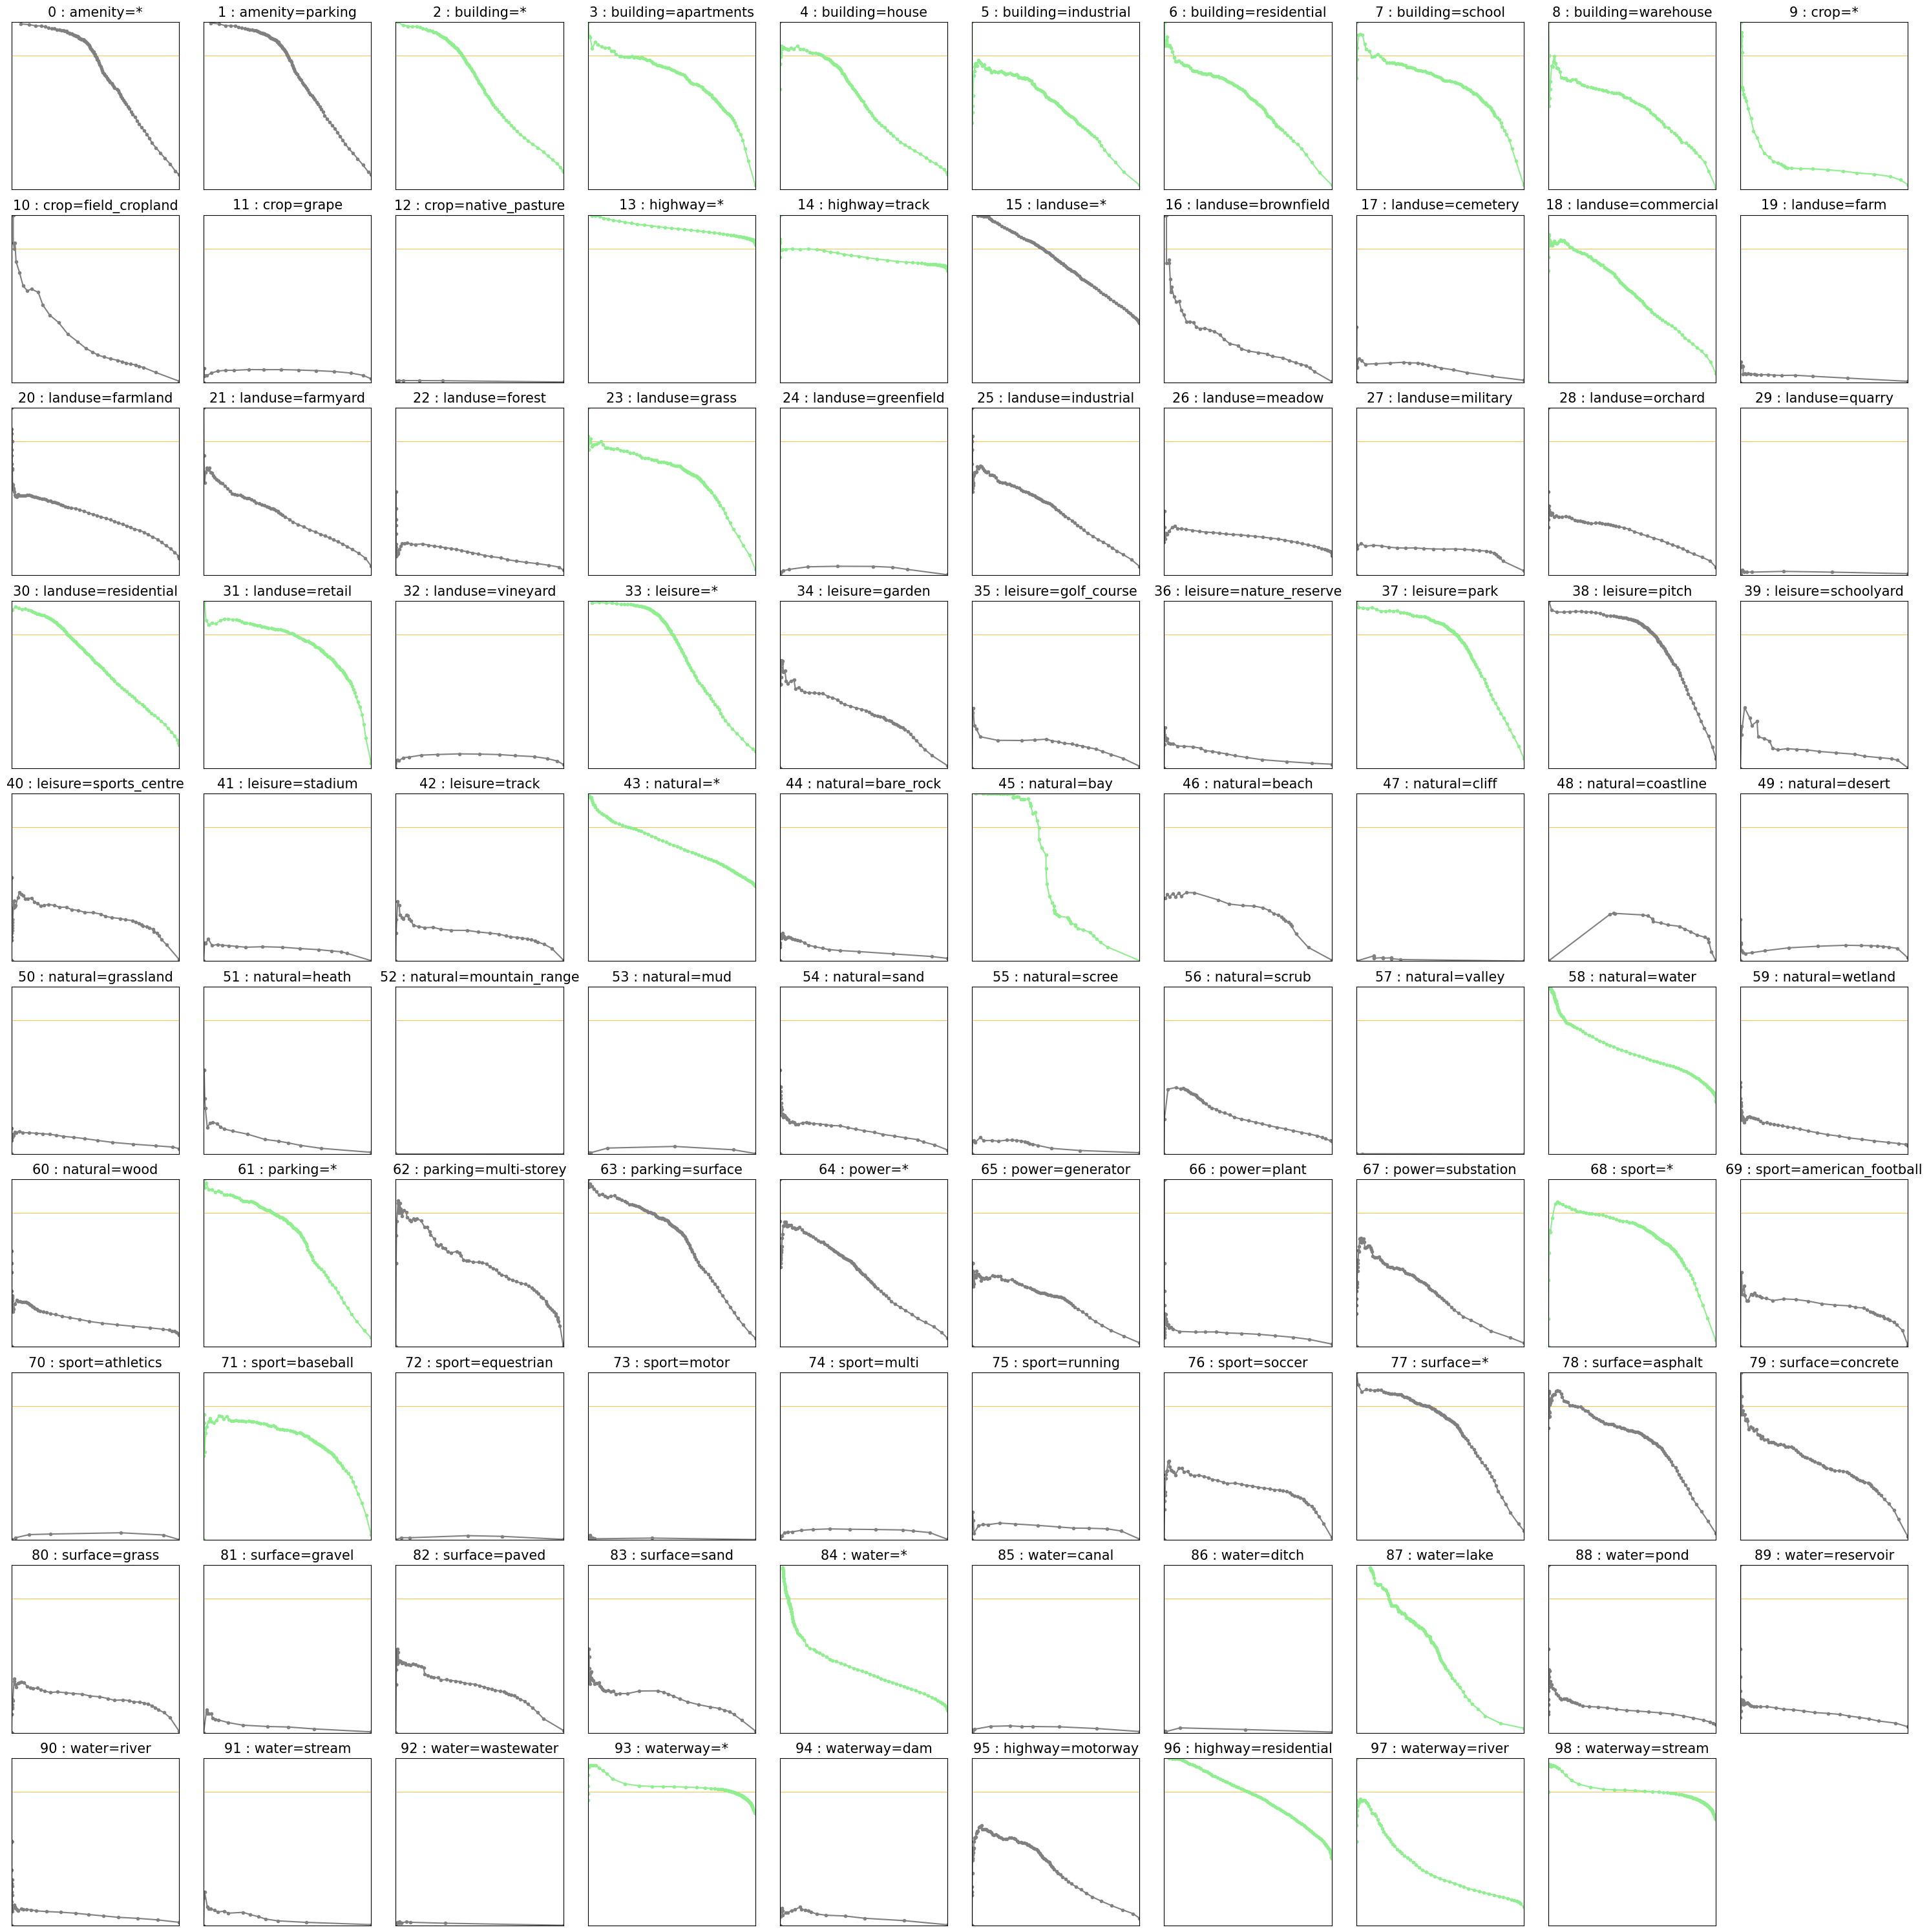

In [23]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [24]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

28
{2: 0.39, 3: 0.55, 4: 0.48, 5: 0.72, 6: 0.69, 7: 0.58, 8: 0.61, 9: 0.29, 13: 0.0, 14: 0.47, 18: 0.5, 23: 0.69, 30: 0.46, 31: 0.43, 33: 0.34, 37: 0.26, 43: 0.58, 45: 0.28, 58: 0.59, 61: 0.36, 68: 0.53, 71: 0.64, 84: 0.56, 87: 0.62, 93: 0.19, 96: 0.44, 97: 0.5, 98: 0.28}


# Train on retained OSM classes (emb v1)

In [104]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 31, 33, 37, 43, 45, 58, 61, 68,
                  71, 84, 87, 93, 96, 97, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

27
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


In [105]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-17 13:56:48.312 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-17 13:56:51.695 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-17 13:56:51.696 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-17 13:56:52.112 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-17 13:56:52.791 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-17 13:56:52.792 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-17 13:56:5

In [106]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561435

In [107]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.28922 params 0.0383146
epoch   1 step 3662 loss 0.27883 params 0.0630421
epoch   2 step 3662 loss 0.26164 params 0.0932608
epoch   3 step 3662 loss 0.24804 params 0.1244280
epoch   4 step 3662 loss 0.25023 params 0.1554488
epoch   5 step 3662 loss 0.25303 params 0.1864791
epoch   6 step 3662 loss 0.23831 params 0.2178809
epoch   7 step 3662 loss 0.24125 params 0.2493343
epoch   8 step 3662 loss 0.23793 params 0.2810025
epoch   9 step 3662 loss 0.25099 params 0.3123682
epoch  10 step 3662 loss 0.23699 params 0.3436193
epoch  11 step 3662 loss 0.23334 params 0.3748106
epoch  12 step 3662 loss 0.23221 params 0.4057585
epoch  13 step 3662 loss 0.22731 params 0.4364995
epoch  14 step 3662 loss 0.23742 params 0.4670250
epoch  15 step 3662 loss 0.22748 params 0.4973261
epoch  16 step 3662 loss 0.22389 params 0.5275784
epoch  17 step 3662 loss 0.22814 params 0.5578196
epoch  18 step 3662 loss 0.22715 params 0.5880085
epoch  19 step 3662 loss 0.22531 params 0.6180317


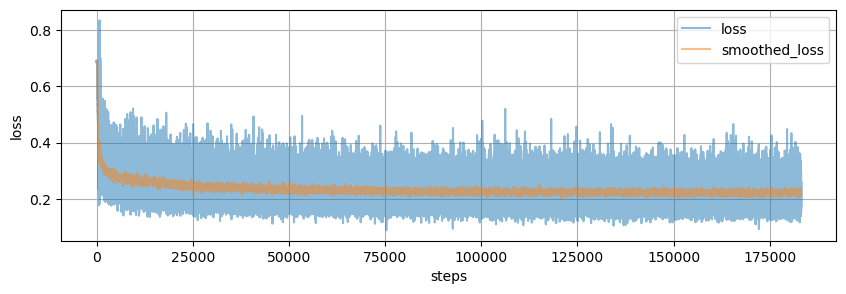

In [108]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [109]:
targets_train = []
predictions_train = []
embeddings_train = []
chip_IDs_train = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for xi in x.detach().numpy():
        embeddings_train.append(xi)
    
    for ti in t.detach().numpy():
        targets_train.append(ti)

    for oi in o.detach().numpy():
        predictions_train.append(oi)

    chip_IDs_train.extend(cid)  # +=

embeddings_train = np.r_[embeddings_train]
targets_train = np.r_[targets_train]
predictions_train = np.r_[predictions_train]
chip_IDs_train = np.r_[chip_IDs_train]
embeddings_train.shape, targets_train.shape, predictions_train.shape, chip_IDs_train.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:16 Time:  0:00:160001


((58598, 768), (58598, 27), (58598, 27), (58598,))

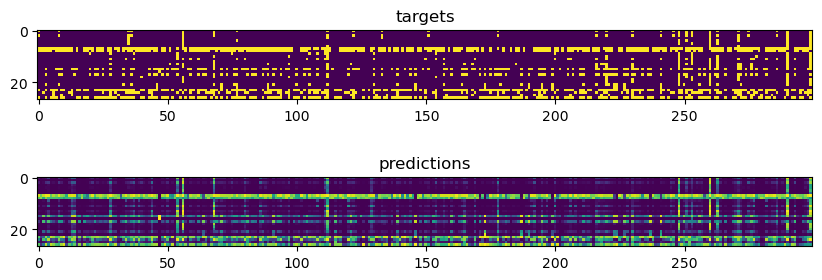

In [110]:
idxs = np.random.permutation(len(targets_train))[:300]

fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets_train[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions_train[idxs].T, interpolation='none');
ax[1].set_title("predictions");

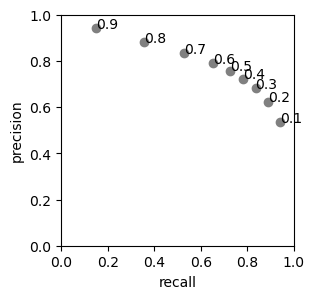

In [111]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets_train.flatten(), predictions_train.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [112]:
R_train = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_train[:,c], predictions_train[:,c] >= thres) for c in range(targets_train.shape[-1])]
    r = pd.DataFrame(r)
    R_train.append(r)

R_train = np.array([r.values for r in R_train])
R_train.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:350003


(100, 27, 2)

<Figure size 640x480 with 0 Axes>

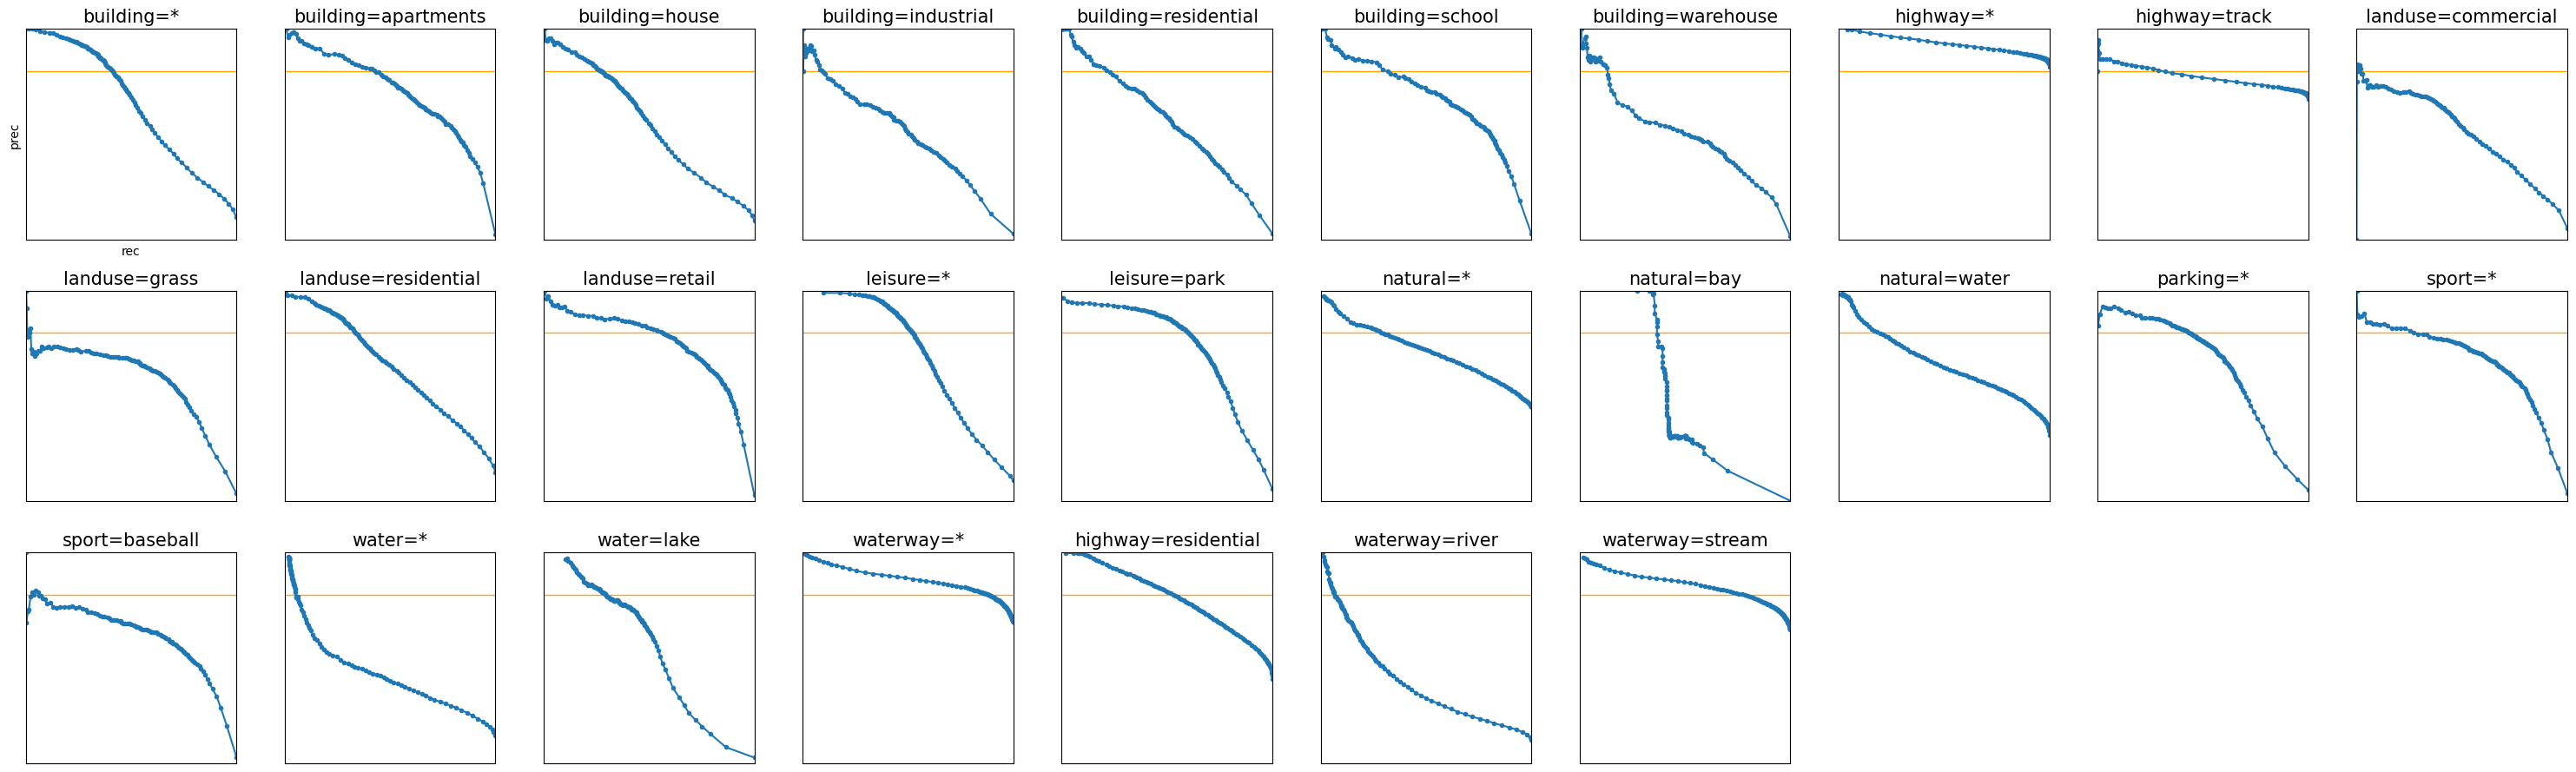

In [113]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=1, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R_train[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R_train[i, c, :] and np.isfinite(list(R_train[i, c, :])).all():
    #         ax.text(*R_train[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

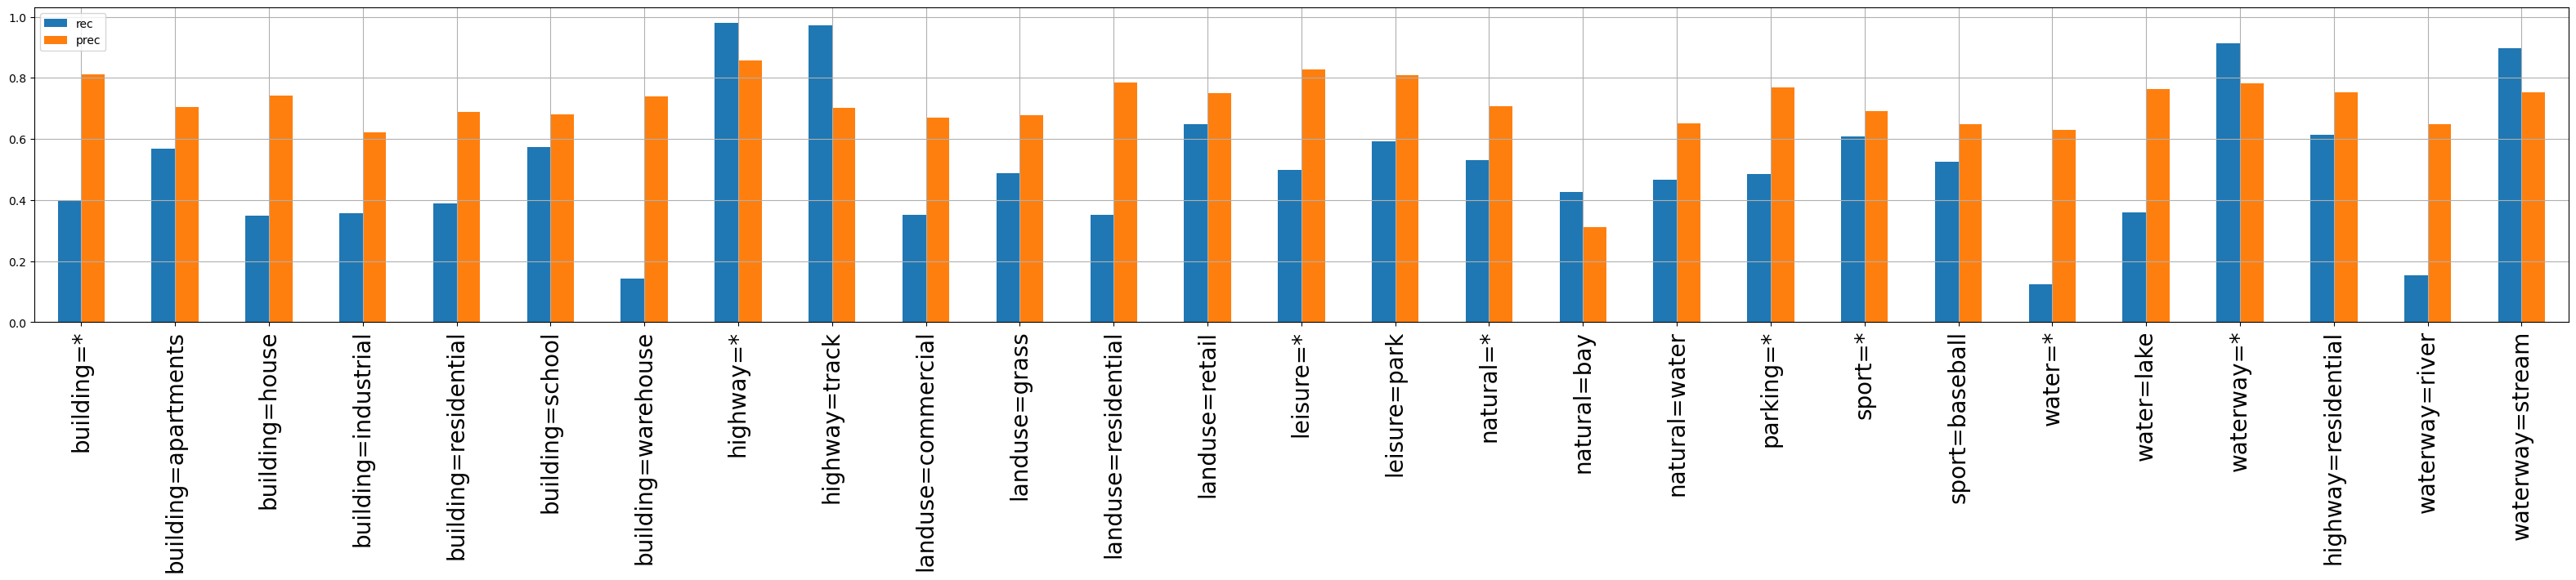

In [114]:
ax = pd.DataFrame(R_train[50], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[classes_retain[i]] for i in range(len(classes_retain))), rotation=90, fontsize=20);

<Figure size 640x480 with 0 Axes>

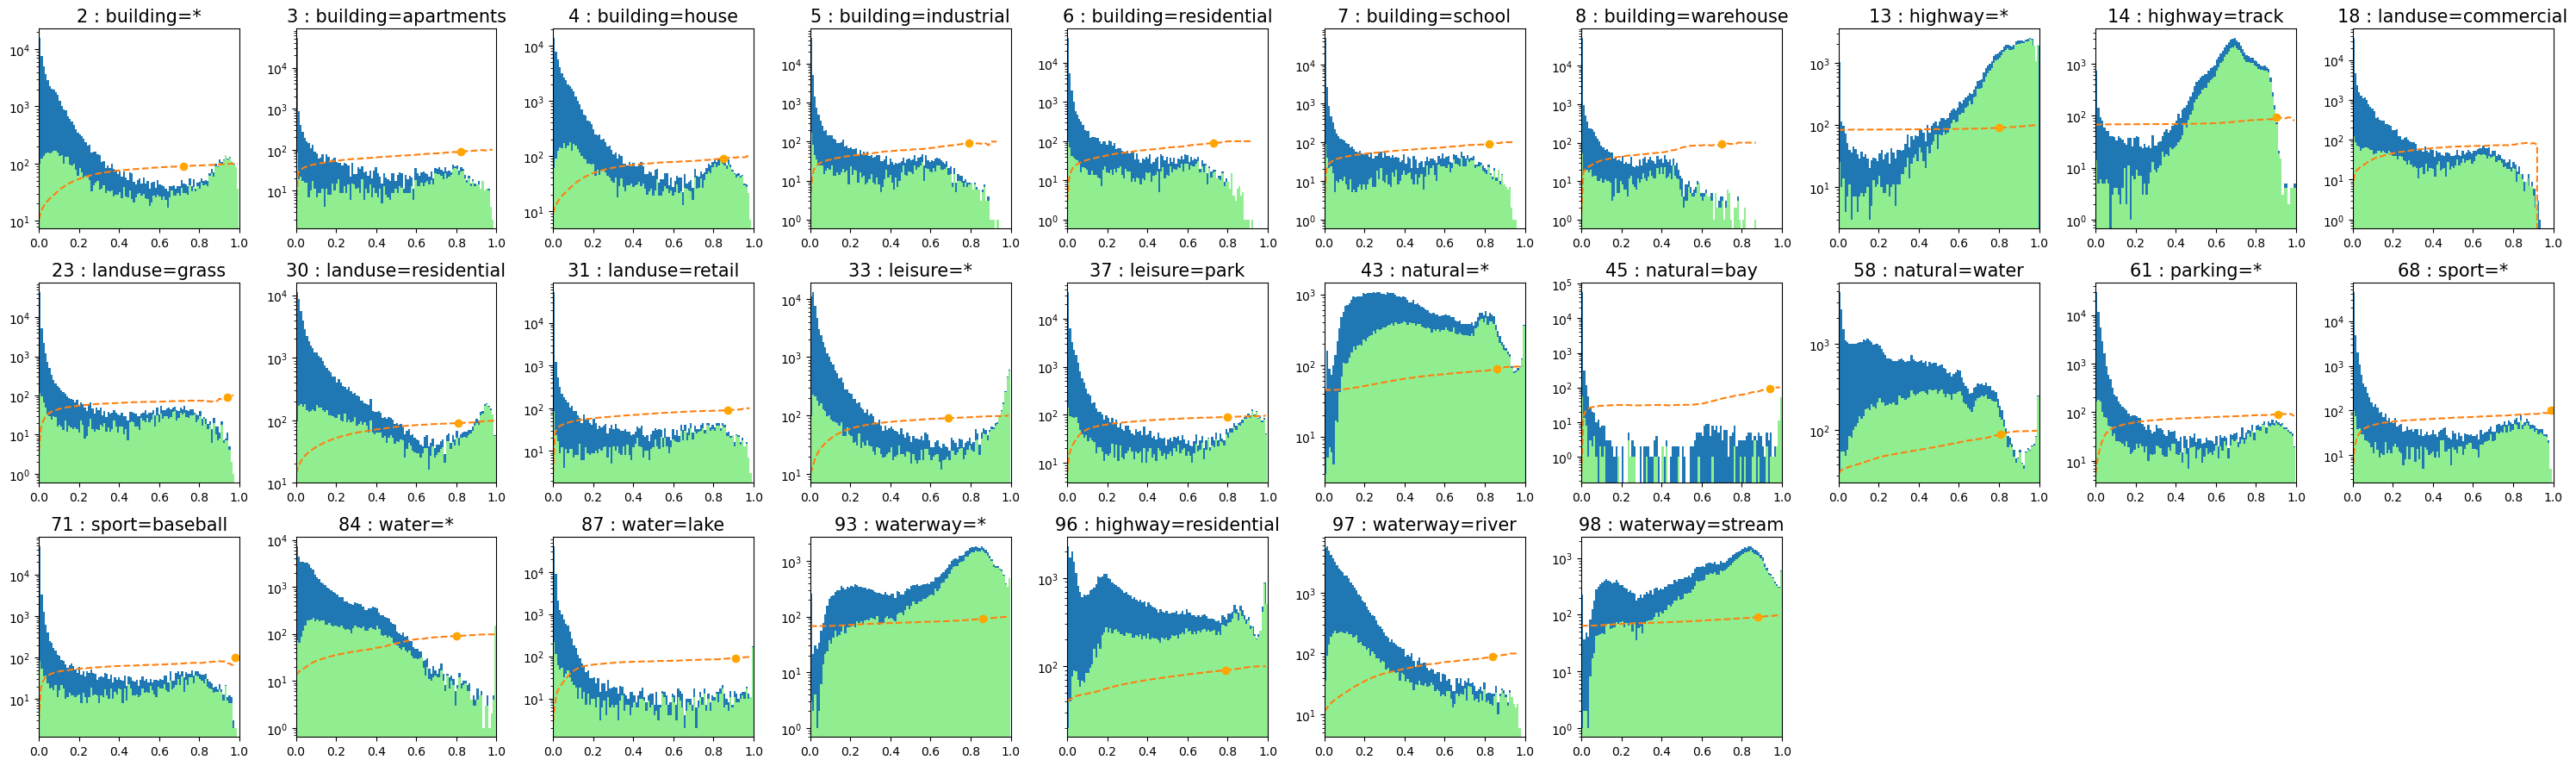

In [115]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions_train[:, c], bins=100);
    plt.hist(predictions_train[targets_train[:, c] > 0, c], bins=100, color='lightgreen');
    plt.plot(np.linspace(0, .99, 100), R_train[:, c, 1]*100, '--');
    is_high_prec = (R_train[:, c, 1] >= .9)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R_train[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{classes_retain[c]} : {name_dict[classes_retain[c]]}", fontsize=15);

#### Modify the labels for instances of low precision

In [116]:
print(conf.dataloader.metadata_file)
df = gp.read_parquet(conf.dataloader.metadata_file)

/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet


In [118]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_train[:, i, 1] >= .85)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

27
{2: 0.58, 3: 0.75, 4: 0.78, 5: 0.75, 6: 0.68, 7: 0.75, 8: 0.58, 13: 0.37, 14: 0.85, 18: 0.5, 23: 0.94, 30: 0.65, 31: 0.71, 33: 0.55, 37: 0.62, 43: 0.82, 45: 0.91, 58: 0.77, 61: 0.76, 68: 0.93, 71: 0.98, 84: 0.7, 87: 0.83, 93: 0.75, 96: 0.69, 97: 0.81, 98: 0.77}


In [119]:
df_modified = df.copy()
targets2_train = targets_train.copy()
for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_train[:, i] < prob_cutoff[c])
    targets2_train[alter_mask, i] = 0
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_train[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


#### Repeat this relabeling process for the val and test datasets

##### Val

In [120]:
targets_val, predictions_val, chip_IDs_val = [], [], []
dlval = dl.val_dataloader()
for batch in pbar(dlval):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for ti in t.detach().numpy():
        targets_val.append(ti)
    for oi in o.detach().numpy():
        predictions_val.append(oi)
    chip_IDs_val.extend(cid)  # +=

targets_val = np.r_[targets_val]
predictions_val = np.r_[predictions_val]
chip_IDs_val = np.r_[chip_IDs_val]
targets_val.shape, predictions_val.shape, chip_IDs_val.shape

100% (739 of 739) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


((11822, 27), (11822, 27), (11822,))

In [121]:
R_val = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_val[:,c], predictions_val[:,c] >= thres) for c in range(targets_val.shape[-1])]
    r = pd.DataFrame(r)
    R_val.append(r)

R_val = np.array([r.values for r in R_val])
R_val.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:070000


(100, 27, 2)

In [122]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_val[:, i, 1] >= .85)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_val[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_val[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

27
{2: 0.67, 3: 0.88, 4: 0.92, 5: 0.79, 6: 0.5, 7: 0.83, 8: 0.69, 13: 0.67, 14: 0.89, 18: 0.5, 23: 0.5, 30: 0.94, 31: 0.67, 33: 0.58, 37: 0.66, 43: 0.86, 45: 0.92, 58: 0.82, 61: 0.79, 68: 0.5, 71: 0.5, 84: 0.78, 87: 0.86, 93: 0.82, 96: 0.67, 97: 0.83, 98: 0.88}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


##### Test

In [123]:
targets_test, predictions_test, chip_IDs_test = [], [], []
dltest = dl.test_dataloader()
for batch in pbar(dltest):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)
    for ti in t.detach().numpy():
        targets_test.append(ti)
    for oi in o.detach().numpy():
        predictions_test.append(oi)
    chip_IDs_test.extend(cid)  # +=

targets_test = np.r_[targets_test]
predictions_test = np.r_[predictions_test]
chip_IDs_test = np.r_[chip_IDs_test]
targets_test.shape, predictions_test.shape, chip_IDs_test.shape

100% (817 of 817) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


((13071, 27), (13071, 27), (13071,))

In [124]:
R_test = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_test[:,c], predictions_test[:,c] >= thres) for c in range(targets_test.shape[-1])]
    r = pd.DataFrame(r)
    R_test.append(r)

R_test = np.array([r.values for r in R_test])
R_test.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:080000


(100, 27, 2)

In [125]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_test[:, i, 1] >= .85)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_test[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_test[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

27
{2: 0.57, 3: 0.98, 4: 0.98, 5: 0.91, 6: 0.77, 7: 0.82, 8: 0.5, 13: 0.14, 14: 0.87, 18: 0.91, 23: 0.79, 30: 0.82, 31: 0.64, 33: 0.53, 37: 0.53, 43: 0.83, 45: 0.98, 58: 0.82, 61: 0.8, 68: 0.88, 71: 0.82, 84: 0.77, 87: 0.87, 93: 0.8, 96: 0.67, 97: 0.79, 98: 0.84}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


---

In [126]:
df_modified.to_parquet(
    "/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec85pc_emb-v1s2.parquet"
)

# Retrain on retained classes and modified targets (emb v1)

Note: removing baseball, grass

In [147]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  30, 31, 33, 37, 43, 45, 58, 61, 68, 84,
                  87, 93, 96, 97, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

25
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
30 landuse=residential
31 landuse=retail
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
84 water=*
87 water=lake
93 waterway=*
96 highway=residential
97 waterway=river
98 waterway=stream


In [148]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.metadata_file = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec85pc_emb-v1s2.parquet'
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-17 14:46:04.294 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-17 14:46:07.686 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-17 14:46:07.686 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-17 14:46:08.541 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-17 14:46:09.225 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-17 14:46:09.226 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-17 14:46:0

In [149]:
dltrain = dl.train_dataloader()
m2 = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m2.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m2.parameters()])

561177

In [150]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m2(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m2.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.14744 params 0.0387954
epoch   1 step 3662 loss 0.13003 params 0.0634018
epoch   2 step 3662 loss 0.11513 params 0.0943411
epoch   3 step 3662 loss 0.11403 params 0.1258914
epoch   4 step 3662 loss 0.10985 params 0.1573465
epoch   5 step 3662 loss 0.09776 params 0.1889941
epoch   6 step 3662 loss 0.10405 params 0.2205366
epoch   7 step 3662 loss 0.09417 params 0.2521157
epoch   8 step 3662 loss 0.08794 params 0.2840432
epoch   9 step 3662 loss 0.08351 params 0.3159922
epoch  10 step 3662 loss 0.08665 params 0.3479417
epoch  11 step 3662 loss 0.09036 params 0.3799786
epoch  12 step 3662 loss 0.08363 params 0.4121088
epoch  13 step 3662 loss 0.07445 params 0.4443168
epoch  14 step 3662 loss 0.07732 params 0.4767106
epoch  15 step 3662 loss 0.07588 params 0.5091927
epoch  16 step 3662 loss 0.07890 params 0.5416995
epoch  17 step 3662 loss 0.07361 params 0.5741526
epoch  18 step 3662 loss 0.07601 params 0.6067282
epoch  19 step 3662 loss 0.07206 params 0.6393303


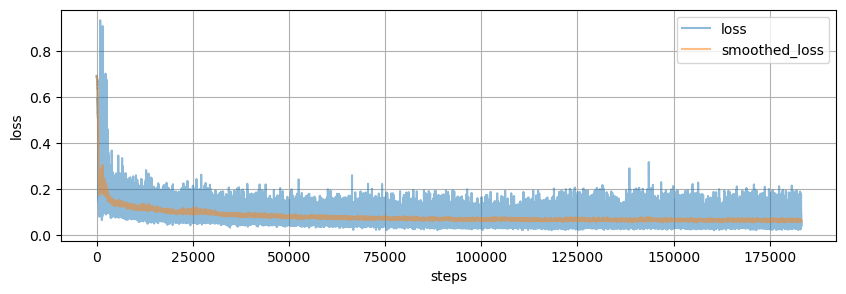

In [151]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss"); #plt.yscale('log');

In [152]:
targets2 = []
predictions2 = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    o = m2(x)

    for ti in t.detach().numpy():
        targets2.append(ti)
    for oi in o.detach().numpy():
        predictions2.append(oi)

targets2 = np.r_[targets2]
predictions2 = np.r_[predictions2]
targets2.shape, predictions2.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:14 Time:  0:00:140001


((58598, 25), (58598, 25))

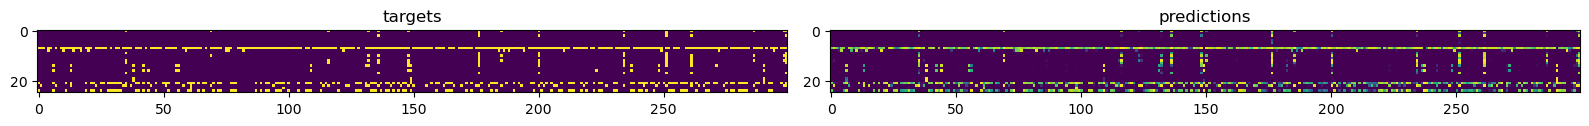

In [153]:
idxs = np.random.permutation(len(targets2))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets2[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions2[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")

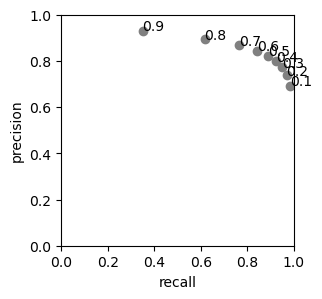

In [154]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets2.flatten(), predictions2.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [155]:
R2 = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets2[:,c], predictions2[:,c] >= thres) for c in range(targets2.shape[-1])]
    r = pd.DataFrame(r)
    R2.append(r)

R2 = np.array([r.values for r in R2])
R2.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:310002


(100, 25, 2)

<Figure size 640x480 with 0 Axes>

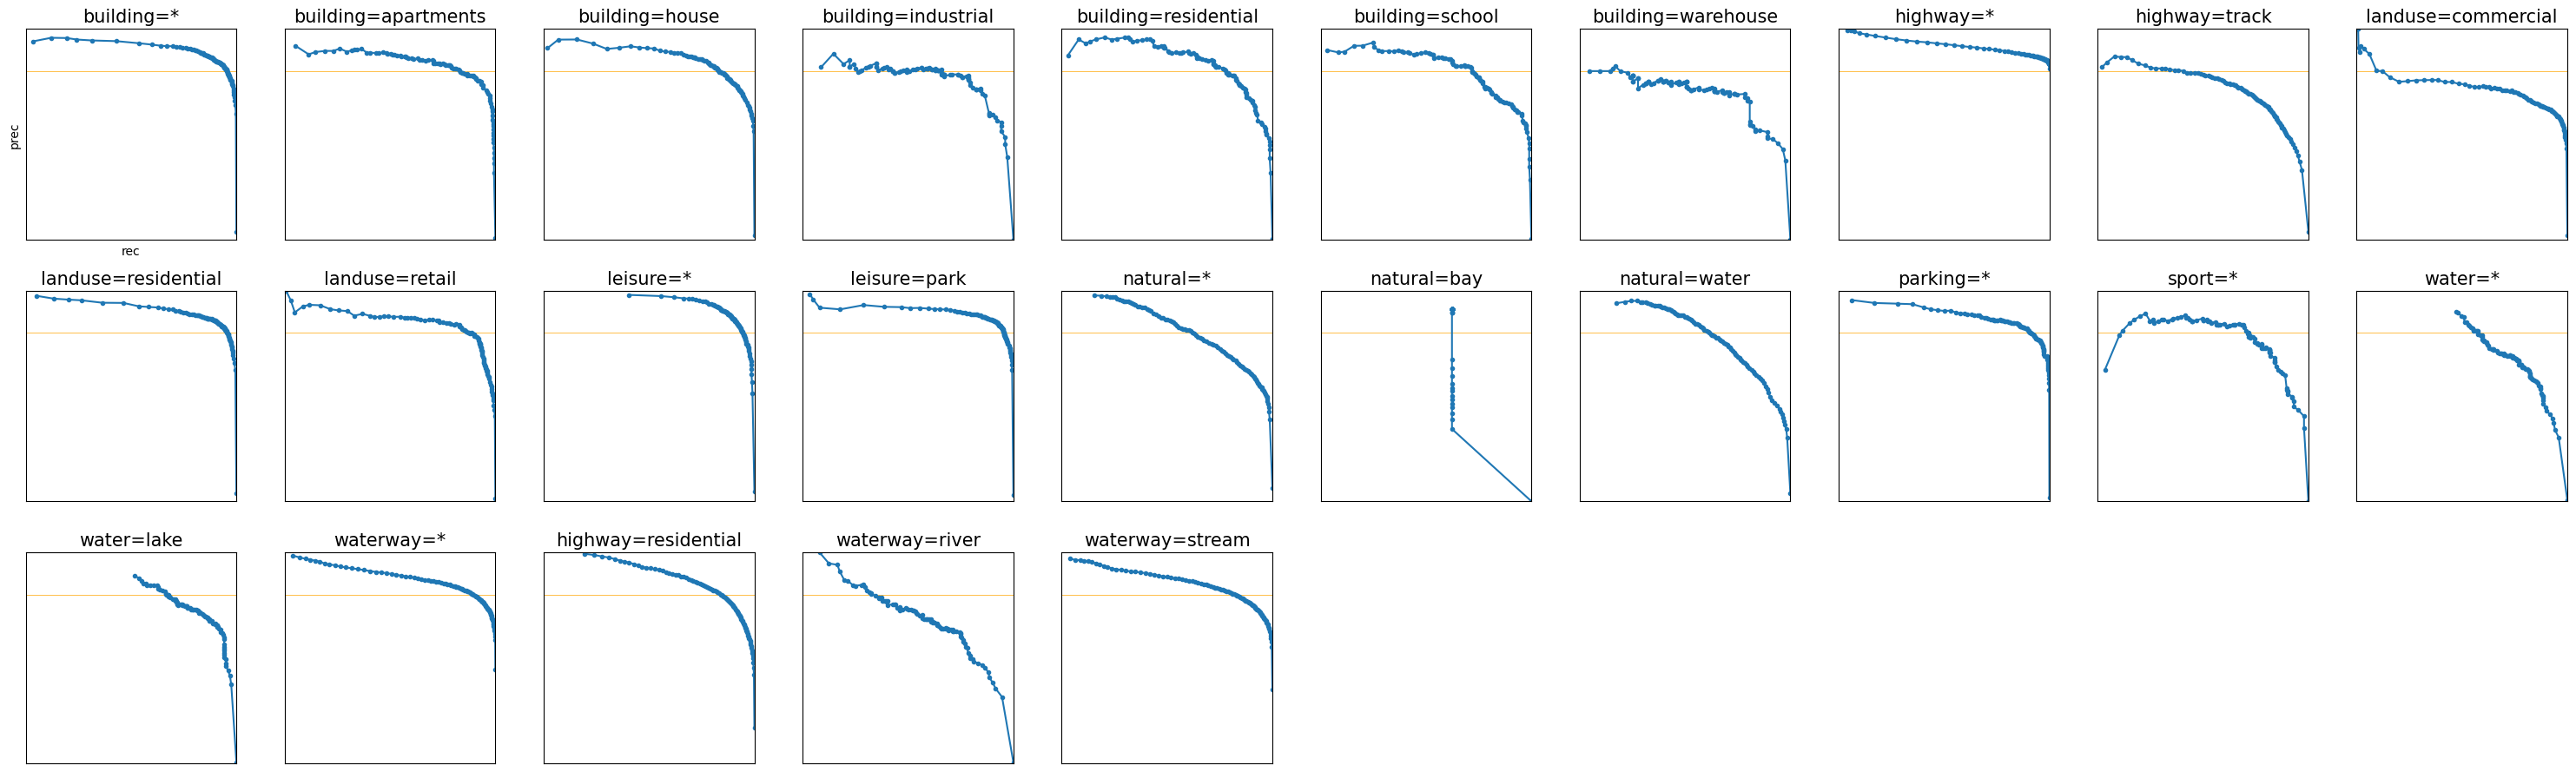

In [156]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R2[:, c, :].T, marker='o', ls='-', markersize=3);
plt.tight_layout();

---

prec >= .7, v1.0 embeddings
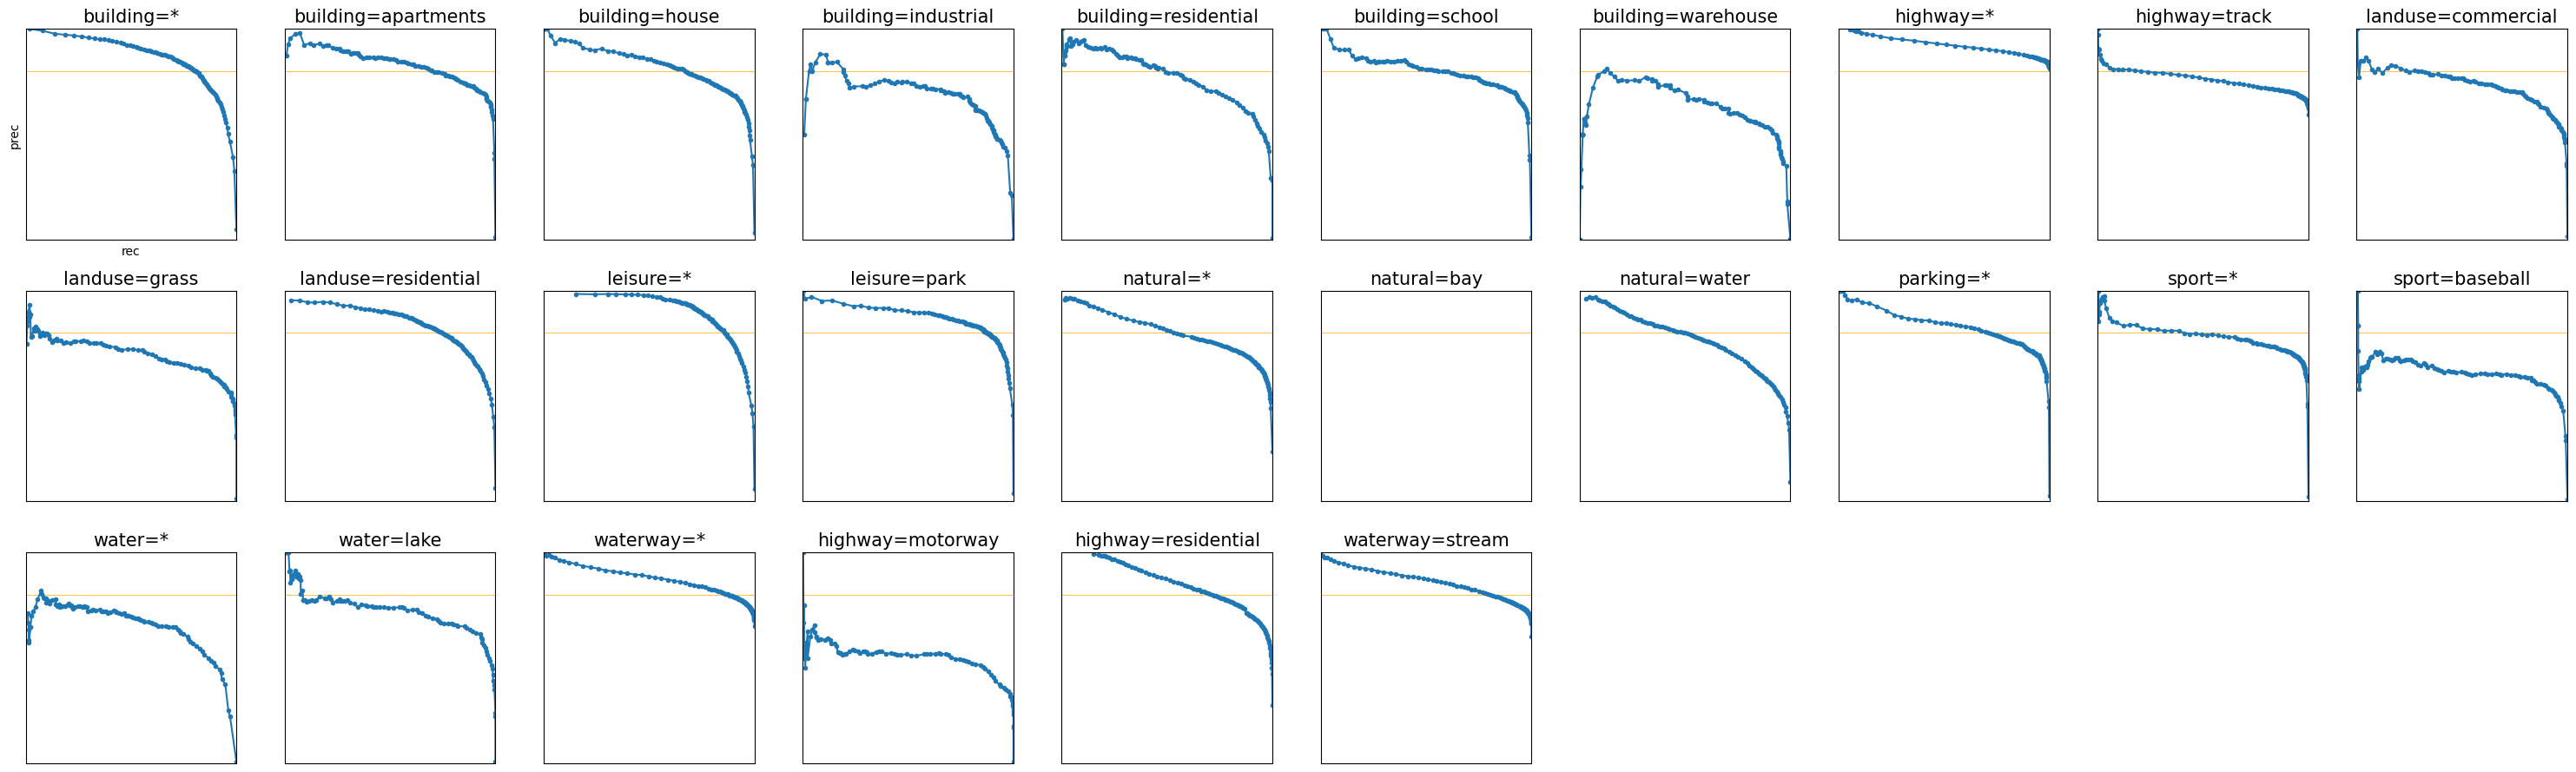

prec >= .8, v1.0 embeddings
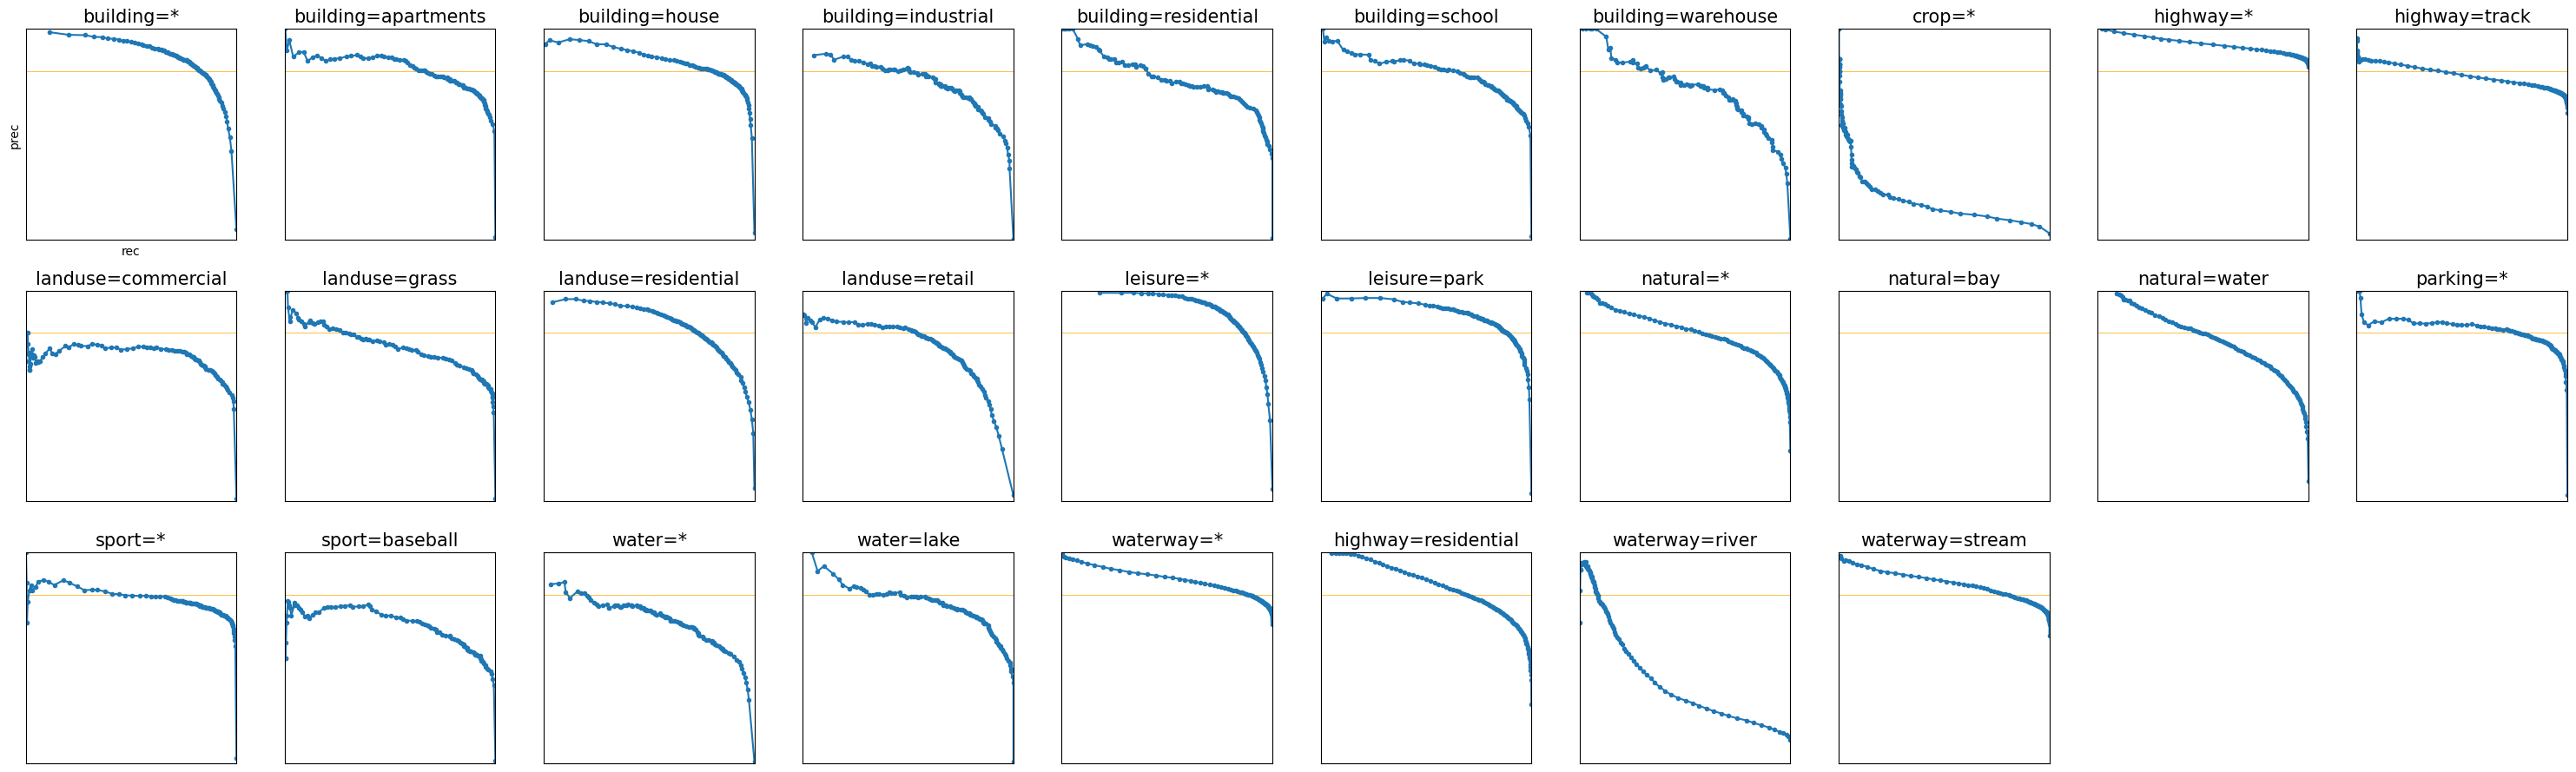

prec >= .85, v1.0 embeddings
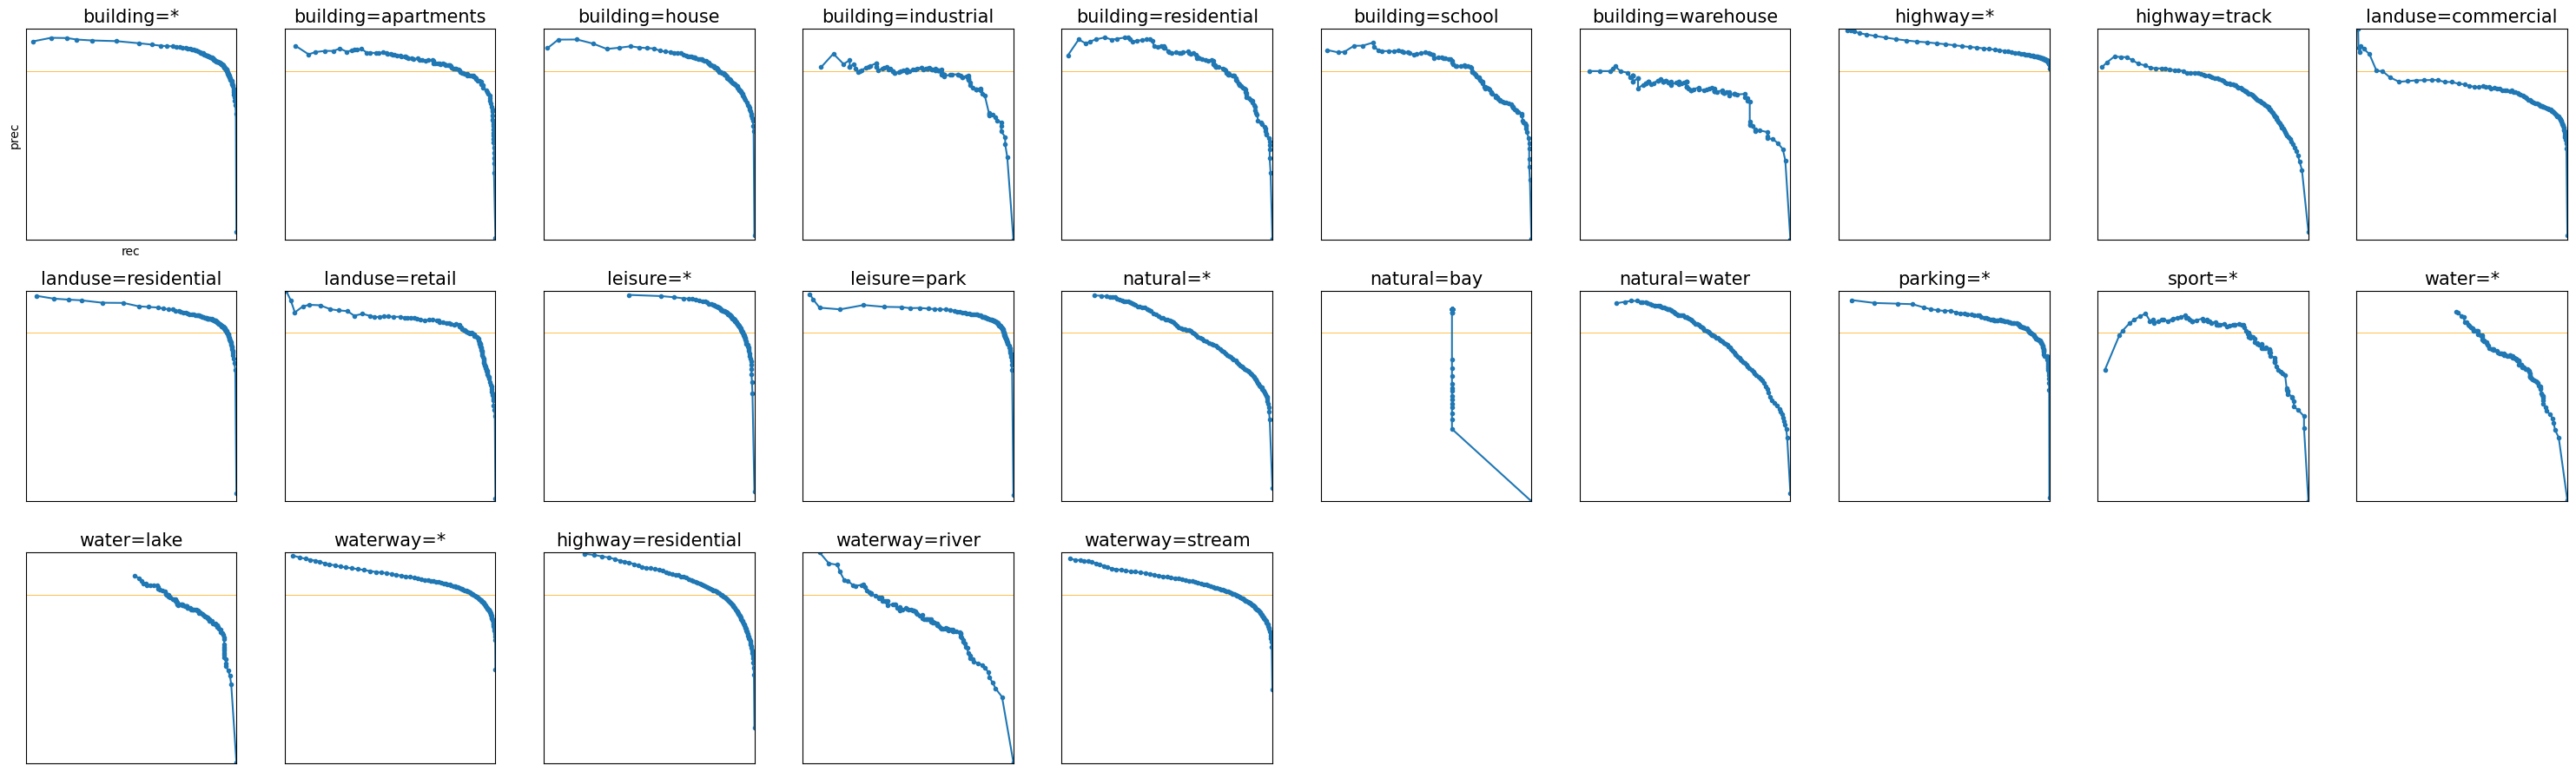

prec >= 0 (orig. labels), v1.0 embeddings
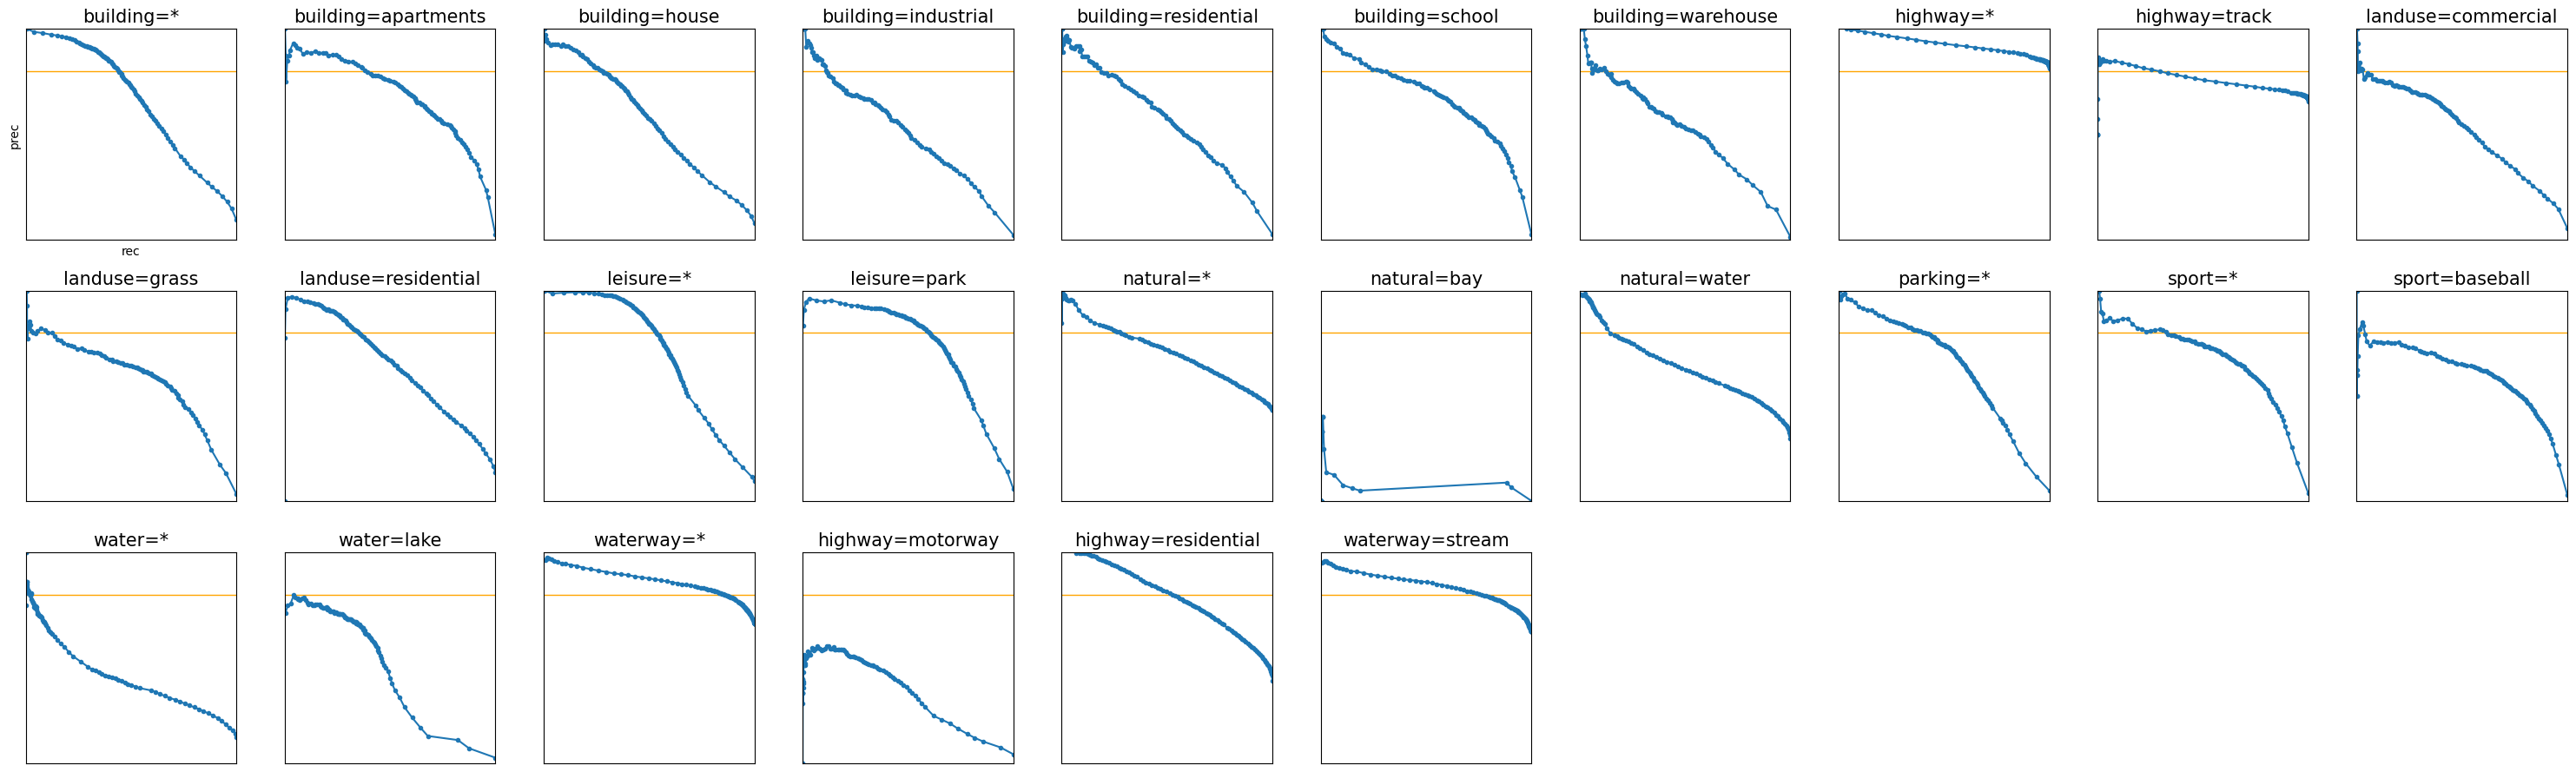


---

<Figure size 640x480 with 0 Axes>

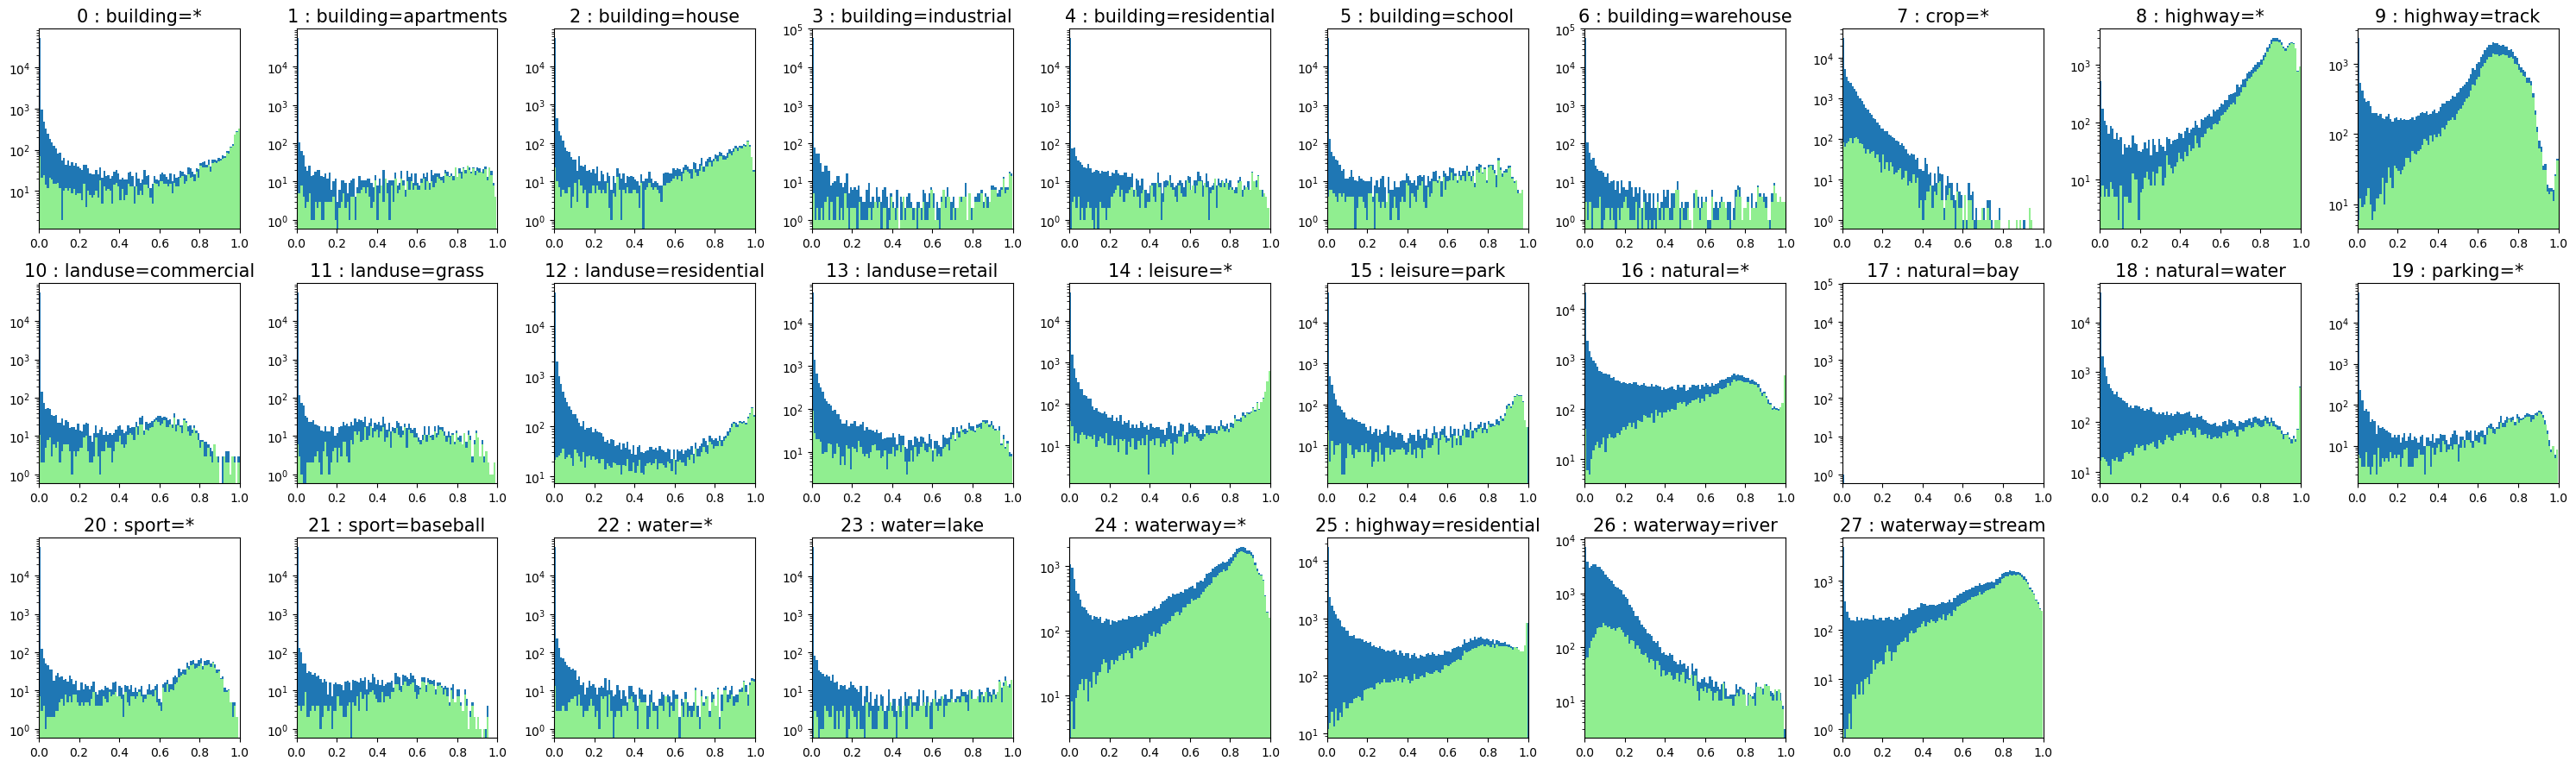

In [60]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions2[:, c], bins=100);
    plt.hist(predictions2[targets2[:, c] > 0, c], bins=100, color='lightgreen');
    # plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    # is_high_prec = (R[:, c, 1] >= .4)
    # if is_high_prec.sum() > 0:
    #     i_nz = is_high_prec.nonzero()[0][0]
    #     plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[classes_retain[c]]}", fontsize=15);